In [1]:
#Solves the SSD set of equations

#eqn : du/dt = R - r_m*U
#eqn : R = 0.25 * k * (k_plus_square - k_e_square) * C_13 
#eqn : dC/dt = A(U)*C + C*Transpose(A(U)) + eps*Q
#eqn : A(U) = W + UL

import numpy as np
import matplotlib.pyplot as plt


In [2]:

class Simulation:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time, U, C, current_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = U
        # self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.C = C

        self.current_time = current_time

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R


In [3]:

def make_plots(sims):

    time_array = np.arange(0, sims[0].total_time, .001)
    fig, axs = plt.subplots(3, 2, figsize = (10, 6))

    # for i in range(10):
    #     axs[i, 0].plot(time_array, sims[i].U_History)
    #     axs[i, 0].set_title(f"U History at {sims[i].current_time}")
    #     axs[i, 0].grid()
    #     axs[i, 1].plot(time_array, sims[i].R_History)
    #     axs[i, 1].set_title(f"R Values at {sims[i].current_time}")
    #     axs[i, 1].grid()
    for i in (0,1,2):
        axs[i, 0].plot(time_array, sims[i+3].U_History, color = 'red')
        axs[i, 0].set_title(f"U History at {sims[i+3].current_time }")
        axs[i, 0].set_xlabel('Time')
        axs[i, 0].set_ylabel('Jet Velocity')
        axs[i, 0].set_ylim(-.5, .5)
        axs[i, 0].grid()

        

        axs[i, 1].plot(time_array, sims[i+3].R_History, color = 'red')
        axs[i, 1].set_title(f"R Values at {sims[i+3].current_time}")
        axs[i, 1].set_xlabel('Time')
        axs[i, 1].set_ylabel('Reynolds Stress')
        axs[i, 1].set_ylim(-3.75, 3.75)
        axs[i, 1].grid()
        if i in (0,1,2):
            axs[i, 0].set_title(f"T=T{(sims[i+3].current_time + 1)//100 - 5}")
            axs[i, 1].set_title(f"T=T{(sims[i+3].current_time + 1)//100 - 5}")
            if i == 1:
                axs[i, 0].set_title(f"T={(sims[i+3].current_time + 1)//100 - 5} (Time of Reversal)")
                axs[i, 1].set_title(f"T={(sims[i+3].current_time + 1)//100 - 5} (Time of Reversal)")
            if i == 2:
                axs[i, 0].set_title(f"T=T+{(sims[i+3].current_time + 1)//100 - 5}")
                axs[i, 1].set_title(f"T=T+{(sims[i+3].current_time + 1)//100 - 5}")


    plt.subplots_adjust(wspace=.4)
    plt.subplots_adjust(hspace=.4)
    plt.tight_layout()
    plt.show()


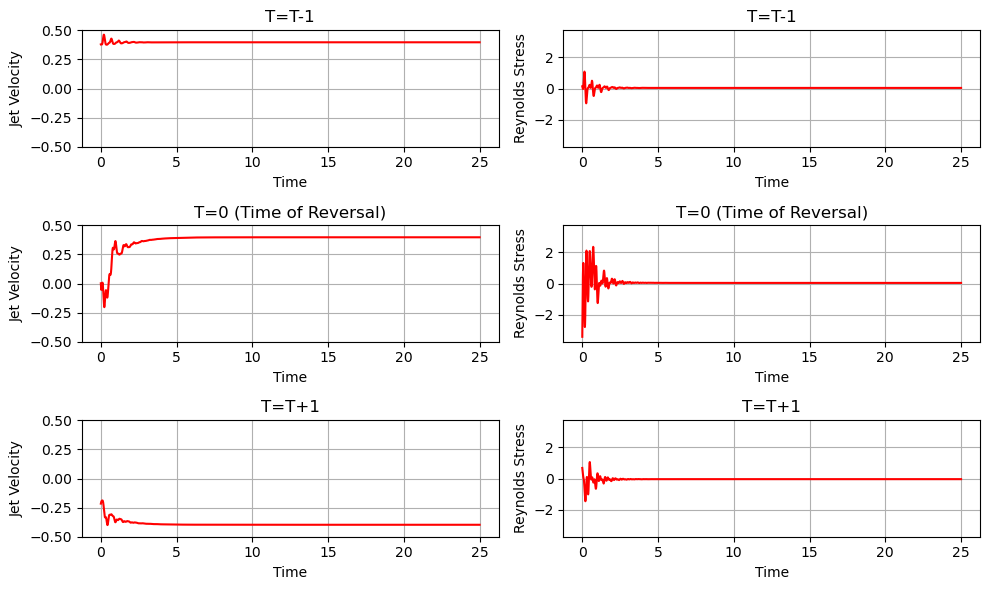

In [4]:


if __name__ == "__main__":
    epsilon = 0.12394270273516043
    N_0_squared = 318.8640217310387
    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 25

    k_e_square = k**2 + m**2

    C_11 = (2*epsilon/k_e_square)*(2-(np.square(k) * N_0_squared/(k_e_square + np.square(k)*N_0_squared)))
    C_12 = -(2*epsilon*k*N_0_squared)/(k_e_square + np.square(k)*N_0_squared)
    C_22 = (2*epsilon*np.square(k)*np.square(N_0_squared))/(k_e_square + np.square(k)*N_0_squared)


    U_entries = np.array([0.5022827801804544, 0.40950991628144395, 0.36386063053663087, 0.3794275046949516, 0.0021052785076200523, -0.21572820861504546, -0.33933857396878414, -0.44582272206193174, -0.37404536864576843, -0.33003068506849215])
    C_entries = np.array([[[3.209225737451153e-05,
  0.004308328634512763,
  -2.2865617299652913e-06,
  -0.04298516464145379],
 [0.004308328634512763,
  0.5783854780407179,
  -0.00030696685685982993,
  -5.770682115715138],
 [-2.2865617299652913e-06,
  -0.00030696685685982993,
  1.6291669619645895e-07,
  0.003062677432702768],
 [-0.04298516464145379,
  -5.770682115715138,
  0.003062677432702768,
  57.57539451619873]], [[4.674061556047324e-06,
  -0.015152332601359049,
  -5.253684734195421e-06,
  -0.010543186474467389],
 [-0.015152332601359049,
  49.120701665804866,
  0.017031350041211486,
  34.17881134504736],
 [-5.253684734195421e-06,
  0.017031350041211486,
  5.905186090373037e-06,
  0.011850630798608194],
 [-0.010543186474467389,
  34.17881134504736,
  0.011850630798608194,
  23.782053296147613]], [[4.2902852820799504e-05,
  -0.05776262630394941,
  -1.1623135158089199e-05,
  0.020913647682537603],
 [-0.05776262630394941,
  77.76921062722774,
  0.015648908370296363,
  -28.15727011871854],
 [-1.1623135158089199e-05,
  0.015648908370296363,
  3.148911133427319e-06,
  -0.005665873891373166],
 [0.020913647682537603,
  -28.15727011871854,
  -0.005665873891373166,
  10.194675426741465]], [[0.00014732175533658907,
  -0.10022658170538411,
  4.334461987889665e-06,
  0.003599936287279282],
 [-0.10022658170538411,
  68.18658695312973,
  -0.002948840159999165,
  -2.4491244189076187],
 [4.334461987889665e-06,
  -0.002948840159999165,
  1.275274020563772e-07,
  0.00010591637983396548],
 [0.003599936287279282,
  -2.4491244189076187,
  0.00010591637983396548,
  0.08796760018818137]], [[0.00037464754867079866,
  -0.43371234047679336,
  -0.0001046607960770223,
  -0.07335717575778004],
 [-0.43371234047679336,
  502.0889498656411,
  0.1211610191599468,
  84.92224892850105],
 [-0.0001046607960770223,
  0.1211610191599468,
  2.9237832395644953e-05,
  0.02049291511451366],
 [-0.07335717575778004,
  84.92224892850105,
  0.02049291511451366,
  14.36356718267584]], [[0.000502036223101408,
  -0.03506758548396667,
  2.044096583350114e-05,
  0.04254621386930327],
 [-0.03506758548396667,
  2.4494956640348073,
  -0.001427815929920163,
  -2.971883149514389],
 [2.044096583350114e-05,
  -0.001427815929920163,
  8.322767660571007e-07,
  0.001732316641764691],
 [0.04254621386930327,
  -2.971883149514389,
  0.001732316641764691,
  3.6056767048198615]], [[2.6475415454580633e-05,
  -0.026549380836582464,
  3.691906861667028e-06,
  0.0009266904809122064],
 [-0.026549380836582464,
  26.623552858504414,
  -0.0037022210832439034,
  -0.9292794115953044],
 [3.691906861667028e-06,
  -0.0037022210832439034,
  5.148238862807293e-07,
  0.00012922384356878395],
 [0.0009266904809122064,
  -0.9292794115953044,
  0.00012922384356878395,
  0.03243594983000424]], [[2.3132908740317164e-06,
  -0.013119841309147893,
  -3.2784103608848675e-06,
  0.006064271697738729],
 [-0.013119841309147893,
  74.40924870689803,
  0.018593521534156204,
  -34.393548698536115],
 [-3.2784103608848675e-06,
  0.018593521534156204,
  4.646183761415681e-06,
  -0.008594323951331568],
 [0.006064271697738729,
  -34.393548698536115,
  -0.008594323951331568,
  15.89743496454513]], [[0.00025615893953517414,
  -0.1361574153724205,
  -9.749944394245619e-06,
  -0.03861531552553974],
 [-0.1361574153724205,
  72.37241766591642,
  0.005182435682917152,
  20.525387735008287],
 [-9.749944394245619e-06,
  0.005182435682917152,
  3.711032527827448e-07,
  0.0014697795822525405],
 [-0.03861531552553974,
  20.525387735008287,
  0.0014697795822525405,
  5.821161642232034]], [[0.00010069930425200607,
  0.10780210165882807,
  -9.21441099886821e-06,
  -0.010822046507882056],
 [0.10780210165882807,
  115.40589290445659,
  -0.009864346914853939,
  -11.585376547187273],
 [-9.21441099886821e-06,
  -0.009864346914853939,
  8.431574645598605e-07,
  0.0009902628932066844],
 [-0.010822046507882056,
  -11.585376547187273,
  0.0009902628932066844,
  1.163033761640206]]])
    
    current_time_entries = np.array([99, 199, 299, 399, 499 ,599, 699, 799, 899, 999])
    sims = [Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time, U_entries[i], C_entries[i], current_time_entries[i]) for i in range(10)]
    for i in sims:
        i.simulate()
    make_plots(sims)
    



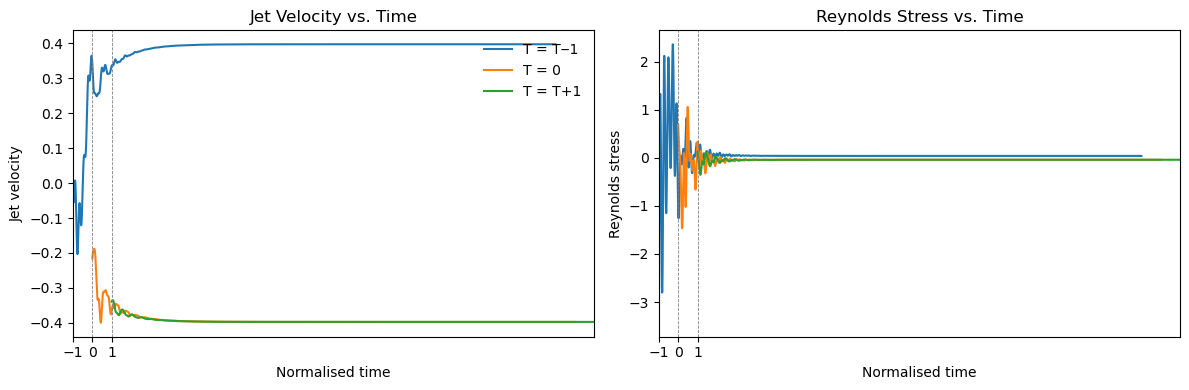

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np           # only needed for the demo placeholders

# ------------------------------------------------------------------
# --- 1.  YOUR DATA  ------------------------------------------------
# Replace these with your actual signals ---------------------------
t_Tm1,  vel_Tm1,  tau_Tm1  = np.arange(0, sims[0].total_time, .001), sims[4].U_History, sims[4].R_History     # T = T‑1   (raw time & data)
t_T0,   vel_T0,   tau_T0   = np.arange(0, sims[0].total_time, .001), sims[5].U_History, sims[5].R_History     # T = 0     (time of reversal)
t_Tp1,  vel_Tp1,  tau_Tp1  = np.arange(0, sims[0].total_time, .001), sims[6].U_History, sims[6].R_History     # T = T+1
# ------------------------------------------------------------------

# 2. Shift the three time bases so that their first samples map to
#    -1, 0 and +1 on the common x–axis, while preserving their
#    individual internal spacing.
common_len = min(len(t_Tm1), len(t_T0), len(t_Tp1))

# 3. Decide how much horizontal separation you want
spacing = 1.0          # –1, 0, +1   ➔ spacing = 1.0
                       # –1.5, 0, +1.5 ➔ spacing = 1.5  etc.

# 4. Convenience indices (read‑only views)
idx = slice(0, common_len)

# ------------------------------------------------------------------
fig, (ax_vel, ax_tau) = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 4), sharex=False)

# ---- Jet velocity -------------------------------------------------
ax_vel.plot(t_Tm1[idx] - t_Tm1[0] - spacing, vel_Tm1[idx], label='T = T‒1')
ax_vel.plot(t_T0[idx]  - t_T0[0],             vel_T0[idx],  label='T = 0')
ax_vel.plot(t_Tp1[idx] - t_Tp1[0] + spacing,  vel_Tp1[idx], label='T = T+1')

ax_vel.set_xlabel('Normalised time')
ax_vel.set_ylabel('Jet velocity')
ax_vel.set_title('Jet Velocity vs. Time')
ax_vel.legend(frameon=False, loc='upper right')

# ---- Reynolds stress ----------------------------------------------
ax_tau.plot(t_Tm1[idx] - t_Tm1[0] - spacing, tau_Tm1[idx], label='T = T‒1')
ax_tau.plot(t_T0[idx]  - t_T0[0],             tau_T0[idx],  label='T = 0')
ax_tau.plot(t_Tp1[idx] - t_Tp1[0] + spacing,  tau_Tp1[idx], label='T = T+1')

ax_tau.set_xlabel('Normalised time')
ax_tau.set_ylabel('Reynolds stress')
ax_tau.set_title('Reynolds Stress vs. Time')

# ---- Cosmetic touches ---------------------------------------------
ticks = [-spacing, 0, spacing]
for ax in (ax_vel, ax_tau):
    ax.set_xticks(ticks)
    for x in ticks:                       # vertical guide lines
        ax.axvline(x, color='gray', lw=0.6, ls='--')

# make the right‑hand plot as long as the left
x_max = t_Tp1[idx][-1] - t_Tp1[0] + spacing
ax_vel.set_xlim(-spacing, x_max)
ax_tau.set_xlim(-spacing, x_max)

fig.tight_layout()
plt.show()


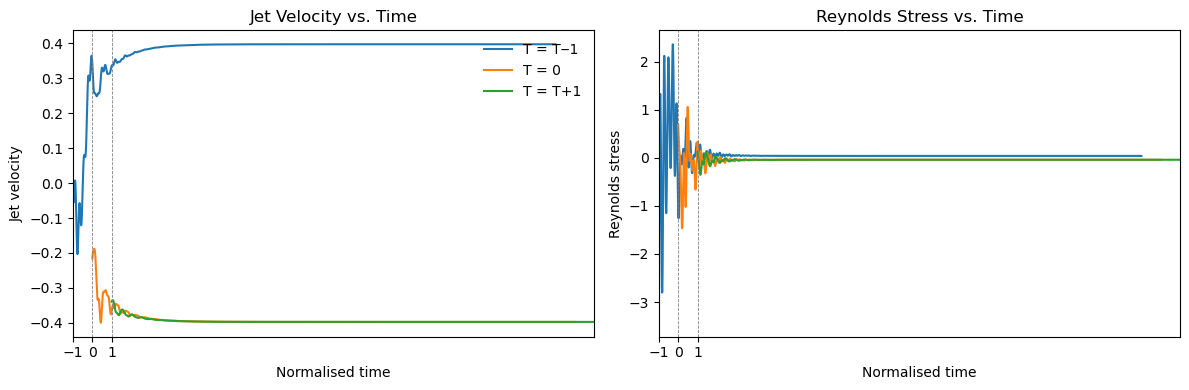

In [6]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

t_Tm1,  vel_Tm1,  tau_Tm1  = np.arange(0, sims[0].total_time, .001), sims[4].U_History, sims[4].R_History     # T = T‑1   (raw time & data)
t_T0,   vel_T0,   tau_T0   = np.arange(0, sims[0].total_time, .001), sims[5].U_History, sims[5].R_History     # T = 0     (time of reversal)
t_Tp1,  vel_Tp1,  tau_Tp1  = np.arange(0, sims[0].total_time, .001), sims[6].U_History, sims[6].R_History     # T = T+1

# How far apart should the reference instants lie on the x–axis?
spacing = 1.0          # ↦ traces will appear at –1, 0, +1
                       # change to 1.5 for –1.5, 0, +1.5, etc.

# The duration everybody must share (smallest record length in *time* units)
common_dur = min(t_Tm1[-1] - t_Tm1[0],
                 t_T0[-1]  - t_T0[0],
                 t_Tp1[-1] - t_Tp1[0])

# ---------------------------------------------------------------
fig, (ax_vel, ax_tau) = plt.subplots(1, 2, figsize=(12, 4))

# Helper: build a transform that shifts a line horizontally
def make_shift(ax, offset):
    """Return a data‑space → data‑space transform that shifts x by *offset*."""
    return mtransforms.Affine2D().translate(offset, 0) + ax.transData

# ---- Jet velocity ---------------------------------------------
ax_vel.plot(t_Tm1, vel_Tm1,
            transform=make_shift(ax_vel, -spacing - t_Tm1[0]),
            label='T = T‒1')

ax_vel.plot(t_T0,  vel_T0,
            transform=make_shift(ax_vel, -t_T0[0]),
            label='T = 0')

ax_vel.plot(t_Tp1, vel_Tp1,
            transform=make_shift(ax_vel, spacing - t_Tp1[0]),
            label='T = T+1')

ax_vel.set_xlabel('Normalised time')
ax_vel.set_ylabel('Jet velocity')
ax_vel.set_title('Jet Velocity vs. Time')
ax_vel.legend(frameon=False, loc='upper right')

# ---- Reynolds stress ------------------------------------------
ax_tau.plot(t_Tm1, tau_Tm1,
            transform=make_shift(ax_tau, -spacing - t_Tm1[0]),
            label='T = T‒1')

ax_tau.plot(t_T0,  tau_T0,
            transform=make_shift(ax_tau, -t_T0[0]),
            label='T = 0')

ax_tau.plot(t_Tp1, tau_Tp1,
            transform=make_shift(ax_tau, spacing - t_Tp1[0]),
            label='T = T+1')

ax_tau.set_xlabel('Normalised time')
ax_tau.set_ylabel('Reynolds stress')
ax_tau.set_title('Reynolds Stress vs. Time')

# ---- Shared cosmetics -----------------------------------------
ticks = [-spacing, 0, spacing]
for ax in (ax_vel, ax_tau):
    ax.set_xticks(ticks)
    # visible window = left trace start … right trace *common* end
    ax.set_xlim(-spacing, spacing + common_dur)
    for x in ticks:                          # reference lines
        ax.axvline(x, lw=0.6, ls='--', color='gray')

fig.tight_layout()
plt.show()


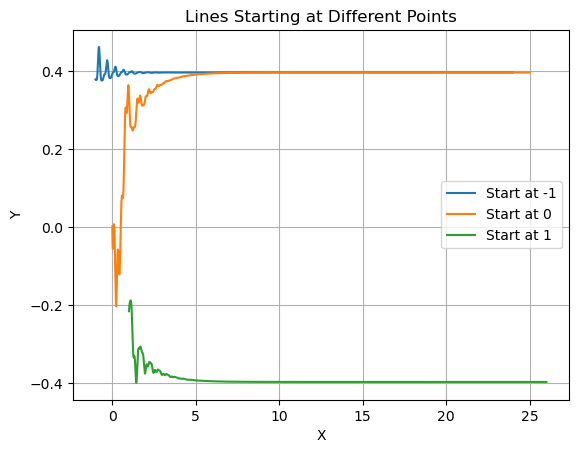

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.arange(0, sims[0].total_time, .001)

# Define your y functions
y1 = sims[3].U_History                # First line: starts at x = -1
y2 = sims[4].U_History         # Second line: starts at x = 0
y3 = sims[5].U_History            # Third line: starts at x = 1

# Adjust x for different starting points
x1 = x - 1
x2 = x
x3 = x + 1

# Plot the lines
plt.plot(x1, y1, label='Start at -1')
plt.plot(x2, y2, label='Start at 0')
plt.plot(x3, y3, label='Start at 1')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lines Starting at Different Points')
plt.legend()
plt.grid(True)
plt.show()


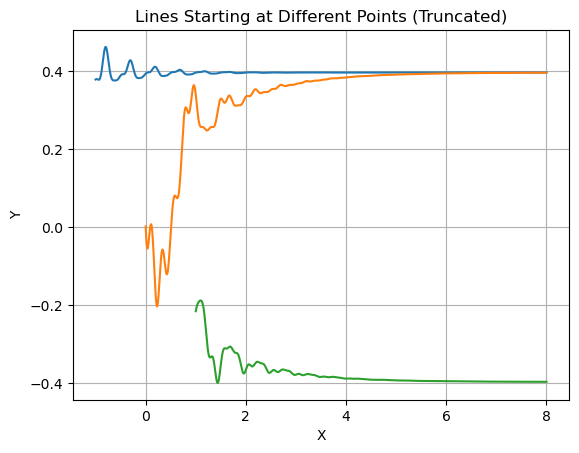

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.arange(0, sims[0].total_time, .001)

# Define your y functions
y1 = sims[3].U_History                # First line: starts at x = -1
y2 = sims[4].U_History         # Second line: starts at x = 0
y3 = sims[5].U_History            # Third line: starts at x = 1

# Shift x arrays
x1 = x - 1
x2 = x
x3 = x + 1

# Define the common maximum endpoint
x_max = 8

# Truncate arrays to only include values <= x_max
mask1 = x1 <= x_max
mask2 = x2 <= x_max
mask3 = x3 <= x_max

x1, y1 = x1[mask1], y1[mask1]
x2, y2 = x2[mask2], y2[mask2]
x3, y3 = x3[mask3], y3[mask3]

# Plot the truncated lines
plt.plot(x1, y1, label='Start at -1')
plt.plot(x2, y2, label='Start at 0')
plt.plot(x3, y3, label='Start at 1')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lines Starting at Different Points (Truncated)')
# plt.legend()
plt.grid(True)
plt.show()


In [49]:
import pandas as pd
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
import random
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

db_username_0 = 'simulationuser'
db_password_0 = 'simulations2024'
db_host_0 = 'localhost'
db_port_0 = '5432'
db_name_0 = 'simulations_data'
table_name_0 = 'composite_data'

connection_string = f"postgresql://{db_username_0}:{db_password_0}@{db_host_0}:{db_port_0}/{db_name_0}"
engine = create_engine(connection_string)
query = f"SELECT * FROM {table_name_0}"
df = pd.read_sql(query, engine)

def average_arrays(*arrays):
    if not arrays:
        raise ValueError("No arrays provided for averaging.")
    
    np_arrays = [np.array(arr) for arr in arrays]
    array_lengths = [len(arr) for arr in np_arrays]

    if len(set(array_lengths)) != 1:
        raise ValueError("All input arrays must have the same length.")
    
    average_array = np.mean(np_arrays, axis=0)
    
    return average_array

def average_eta_arrays(*arrays):
    if not arrays:
        raise ValueError("No arrays provided for averaging.")
    
    np_arrays = [np.array(arr) for arr in arrays]
    array_lengths = [len(arr) for arr in np_arrays]

    if len(set(array_lengths)) != 1:
        raise ValueError("All input arrays must have the same length.")
    
    average_array = np.mean(np.abs(np_arrays), axis=0)
    
    return average_array

average_psi_e = average_arrays(*list(df['psi_e']))
average_b_e = average_arrays(*list(df['b_e']))
average_psi_plus = average_arrays(*list(df['psi_plus']))
average_b_plus = average_arrays(*list(df['b_plus']))
average_U = average_arrays(*list(df['u_list']))
average_R = average_arrays(*list(df['r_list']))
average_k_e_psi_e_list = average_arrays(*list(df['k_e_psi_e_list']))
average_k_e_b_e_list = average_arrays(*list(df['k_e_b_e_list']))
average_k_e_psi_plus_list = average_arrays(*list(df['k_e_psi_plus_list']))
average_k_e_b_plus_list = average_arrays(*list(df['k_e_b_plus_list']))
average_heat_flux_psi_e_b_e_list = average_arrays(*list(df['heat_flux_psi_e_b_e_list']))
average_heat_flux_psi_e_b_plus_list = average_arrays(*list(df['heat_flux_psi_e_b_plus_list']))
average_b_e_psi_plus_list = average_arrays(*list(df['b_e_psi_plus_list']))
average_b_e_b_plus_list = average_arrays(*list(df['b_e_b_plus_list']))
average_psi_plus_b_plus_list = average_arrays(*list(df['psi_plus_b_plus_list']))
average_eta = average_arrays(*list(df['eta_list']))

# average_eta = average_eta_arrays(*list(df['eta_list']))

# average_absolute_eta = [df['eta_list'].tolist()]


# window_size = 5000
# dt = .001
# epsilon = 0.12394270273516043
# N_0_squared = 318.8640217310387



ValueError: x and y must have same first dimension, but have shapes (901,) and (601,)

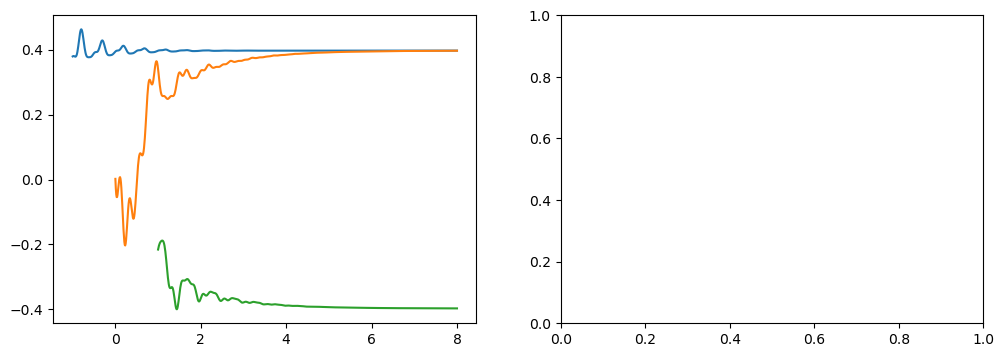

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.arange(0, sims[0].total_time, .01)

# Define y functions for Jet Velocity (U_History)
y1 = sims[3].U_History    # Starts at x = -1
y2 = sims[4].U_History    # Starts at x = 0
y3 = sims[5].U_History    # Starts at x = 1

y1 = y1[::10]  # Downsample for better performance
y2 = y2[::10]  # Downsample for better performance
y3 = y3[::10]  # Downsample for better performance

# Define y functions for Reynolds Stress (R_History)
r1 = sims[3].R_History
r2 = sims[4].R_History
r3 = sims[5].R_History

r1 = r1[::10]  # Downsample for better performance
r2 = r2[::10]  # Downsample for better performance
r3 = r3[::10]  # Downsample for better performance

# Shift x arrays
x1 = x - 1
x2 = x
x3 = x + 1

# Define the common maximum endpoint
x_max = 8

# Truncate arrays to only include values <= x_max
mask1 = x1 <= x_max
mask2 = x2 <= x_max
mask3 = x3 <= x_max

x1, y1, r1 = x1[mask1], y1[mask1], r1[mask1]
x2, y2, r2 = x2[mask2], y2[mask2], r2[mask2]
x3, y3, r3 = x3[mask3], y3[mask3], r3[mask3]

average_U = average_U[399:]  # Ensure average_U matches the length of x1, x2, x3
average_R = average_R[399:]  # Ensure average_R matches the length of x1, x2, x3

# average_U = average_U[:len(x1)]  # Ensure average_U matches the length of x1, x2, x3
# average_R = average_R[:len(x1)]  # Ensure average_R matches the length of x1, x2, x3
# ---------------------------------------------------------------
fig, (ax_vel, ax_tau) = plt.subplots(1, 2, figsize=(12, 4))

# ---- Jet Velocity Plot ----
ax_vel.plot(x1, y1, label='Start at -1')
ax_vel.plot(x2, y2, label='Start at 0')
ax_vel.plot(x3, y3, label='Start at 1')
des_l = len(x1)-300
ax_vel.plot(x1[:des_l], average_U, label='Average U', linestyle='--', color='black')
# ax_vel.plot(x1, average_U, label='Average U', linestyle='--', color='black')

ax_vel.set_xlabel('Normalised Time')
ax_vel.set_ylabel('Jet Velocity')
ax_vel.set_title('Jet Velocity vs. Time (Truncated)')
ax_vel.legend(frameon=False, loc='upper right')
ax_vel.grid(True)

# ---- Reynolds Stress Plot ----
ax_tau.plot(x1, r1, label='Start at -1')
ax_tau.plot(x2, r2, label='Start at 0')
ax_tau.plot(x3, r3, label='Start at 1')
ax_tau.plot(x1[:des_l], average_R, label='Average R', linestyle='--', color='black')
# ax_tau.plot(x1, average_R, label='Average R', linestyle='--', color='black')

ax_tau.set_xlabel('Normalised Time')
ax_tau.set_ylabel('Reynolds Stress')
ax_tau.set_title('Reynolds Stress vs. Time (Truncated)')
ax_tau.legend(frameon=False, loc='upper right')
ax_tau.grid(True)

# ---- Shared layout ----
fig.tight_layout()
plt.show()
